In [11]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import cv2
from PIL import Image
import numpy as np
import os, time
import random
random.seed(0)
import matplotlib.pyplot as plt


readvdnames = lambda x: open(x).read().rstrip().split('\n')

################################# DEFINE DATASET #################################
class TinySegData(Dataset):
    def __init__(self, db_root="TinySeg", img_size=256, phase='train'):
        classes = ['person', 'bird', 'car', 'cat', 'plane', ]
        seg_ids = [1, 2, 3, 4, 5]

        templ_image = db_root + "/JPEGImages/{}.jpg"
        templ_mask = db_root + "/Annotations/{}.png"

        ids = readvdnames(db_root + "/ImageSets/" + phase + ".txt")

        # build training and testing dbs
        samples = []
        for i in ids:
            samples.append([templ_image.format(i), templ_mask.format(i)])
        self.samples = samples
        self.phase = phase
        self.db_root = db_root
        self.img_size = img_size

        self.color_transform = torchvision.transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.2)

        if not self.phase == 'train':
            print ("resize and augmentation will not be applied...")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        if self.phase == 'train':
            return self.get_train_item(idx)
        else:
            return self.get_train_item(idx)

    def get_train_item(self, idx):
        sample = self.samples[idx]
        image = Image.open(sample[0])

        if random.randint(0, 1) > 0:
            image = self.color_transform(image)
        image = np.asarray(image)[..., ::-1]     # to BGR
        seg_gt = (np.asarray(Image.open(sample[1]).convert('P'))).astype(np.uint8)

        image = image.astype(np.float32)
        image = image / 127.5 - 1        # -1~1

        if random.randint(0, 1) > 0:
            image = image[:, ::-1, :]       # HWC
            seg_gt = seg_gt[:, ::-1]

        # random crop to 256x256
        height, width = image.shape[0], image.shape[1]
        if height == width:
            miny, maxy = 0, 256
            minx, maxx = 0, 256
        elif height > width:
            miny = np.random.randint(0, height-256)
            maxy = miny+256
            minx = 0
            maxx = 256
        else:
            miny = 0
            maxy = 256
            minx = np.random.randint(0, width-256)
            maxx = minx+256
        image = image[miny:maxy, minx:maxx, :].copy()
        seg_gt = seg_gt[miny:maxy, minx:maxx].copy()

        if self.img_size != 256:
            new_size = (self.img_size, self.img_size)
            image = cv2.resize(image, new_size, interpolation=cv2.INTER_LINEAR)
            seg_gt = cv2.resize(seg_gt, new_size, interpolation=cv2.INTER_NEAREST)

        image = np.transpose(image, (2, 0, 1))      # To CHW

        # cv2.imwrite("test.png", np.concatenate([(image[0]+1)*127.5, seg_gt*255], axis=0))
        return image, seg_gt, sample

    def get_test_item(self, idx):
        sample = self.samples[idx]
        image = cv2.imread(sample[0])
        seg_gt = (np.asarray(Image.open(sample[1]).convert('P'))).astype(np.uint8)

        image = image.astype(np.float32)
        image = image / 127.5 - 1        # -1~1
        image = np.transpose(image, (2, 0, 1))

        # cv2.imwrite("test.png", np.concatenate([(image[0]+1)*127.5, seg_gt*255], axis=0))
        return image, seg_gt, sample

################################# FUNCTIONS #################################
def get_confusion_matrix(gt_label, pred_label, class_num):
        """
        Calcute the confusion matrix by given label and pred
        :param gt_label: the ground truth label
        :param pred_label: the pred label
        :param class_num: the number of class
        :return: the confusion matrix
        """
        index = (gt_label * class_num + pred_label).astype('int32')

        label_count = np.bincount(index)
        confusion_matrix = np.zeros((class_num, class_num))

        for i_label in range(class_num):
            for i_pred_label in range(class_num):
                cur_index = i_label * class_num + i_pred_label
                if cur_index < len(label_count):
                    confusion_matrix[i_label, i_pred_label] = label_count[cur_index]

        return confusion_matrix

def get_confusion_matrix_for_3d(gt_label, pred_label, class_num):
    confusion_matrix = np.zeros((class_num, class_num))

    for sub_gt_label, sub_pred_label in zip(gt_label, pred_label):
        sub_gt_label = sub_gt_label[sub_gt_label != 255]
        sub_pred_label = sub_pred_label[sub_pred_label != 255]
        cm = get_confusion_matrix(sub_gt_label, sub_pred_label, class_num)
        confusion_matrix += cm
    return confusion_matrix



In [12]:
def draw(epoches,Loss_list,Accuracy_list):
    x1 = range(0, epoches)
    x2 = range(0, epoches)
    y1 = Accuracy_list
    y2 = Loss_list
    plt.subplot(2, 1, 1)
    plt.plot(x1, y1, 'o-')
    plt.title('Test accuracy vs. epoches')
    plt.ylabel('Test accuracy')
    plt.subplot(2, 1, 2)
    plt.plot(x2, y2, '.-')
    plt.xlabel('Test loss vs. epoches')
    plt.ylabel('Test loss')
    plt.show()

In [8]:
class Attention(nn.Module):  
    def __init__(self, embed_size = 3*16*16 , heads = 1, dropout=0.2):  
        super(Attention, self).__init__()  
        self.embed_size = embed_size  
        self.heads = heads  
        self.head_dim = embed_size // heads  

        assert (  
            self.head_dim * heads == embed_size  
        ), "Embedding size must be divisible by heads"  

        self.values = nn.Linear(embed_size, embed_size, bias=False)  
        self.keys = nn.Linear(embed_size, embed_size, bias=False)  
        self.queries = nn.Linear(embed_size, embed_size, bias=False)  
        self.fc_out = nn.Linear(embed_size, embed_size)  

        self.dropout = nn.Dropout(dropout)  

    

    def forward(self, x):    

        values = self.values(x)  # (batch_size, seq_length, embed_size)  
        keys = self.keys(x)      
        queries = self.queries(x)  

       
        # Scaled dot-product attention  
        
        energy = torch.bmm(queries, keys.transpose(-2, -1))  # (batch_size, query_length, key_length)  
        

        # 进行缩放  
        scaling = self.head_dim ** 0.5  
        scaled_energy = energy / scaling  # (batch_size, query_length, key_length)  

        # 应用 softmax  
        attention = nn.functional.softmax(scaled_energy, dim=-1)

        # 计算输出  
        out = torch.bmm(attention, values)  # (batch_size, query_length, head_dim)  
        # 注意：这里的 values 仍然是 (batch_size, heads, seq_length, head_dim)  

    

        # 最后，通过线性层输出  
        out = self.fc_out(out)  
        return self.dropout(out)  
    
class VisionEncoder(nn.Module):  
    def __init__(self, embed_size = 3*16*16, heads = 1, drop_rate=0.2):  
        super(VisionEncoder, self).__init__()  
        self.attention = Attention(embed_size, heads, dropout=drop_rate)  
        self.norm1 = nn.LayerNorm(embed_size)  
        self.norm2 = nn.LayerNorm(embed_size)  
        self.mlp = nn.Sequential(  
            nn.Linear(embed_size, 2048),  
            nn.GELU(),  
            nn.Dropout(drop_rate),  
            nn.Linear(2048, embed_size),  
            nn.Dropout(drop_rate)  
        )  

    def forward(self, x):  
        attention = self.attention(x)  
        x = self.norm1(attention + x)  # Residual Connection  
        mlp_out = self.mlp(x)  
        x = self.norm2(mlp_out + x)  # Residual Connection  
        return x  

class VisionTransformer(nn.Module):  
    def __init__(self, num_classes = 6, embed_size=3*16*16, num_layers=3, heads=1, num_patches=14*14, drop_rate=0.2):  
        super(VisionTransformer, self).__init__()  
        self.patch = nn.Conv2d(3,embed_size,16,16)
        self.encoders = nn.ModuleList(  
            [VisionEncoder(embed_size, heads, drop_rate) for _ in range(num_layers)]  
        )  
        self.norm = nn.LayerNorm(embed_size)  
        self.classifier = nn.Linear(embed_size, num_classes)  
        self.dropout = nn.Dropout(drop_rate)  

    def forward(self, x):  
        x = self.patch(x)
        x = x.flatten(2).permute(0,2,1)
        
        for encoder in self.encoders:  
            x = encoder(x)  
        
        x = self.norm(x)  
        x = self.dropout(x)  
        x = x.mean(dim=1)  # Global average pooling  
        return self.classifier(x)  


In [3]:


def bcdcode(label_arrays, num_classes=6):  
    # 将输入转换为一个 PyTorch 张量，确保是长整型以避免后续问题  
    labels = torch.tensor(label_arrays, dtype=torch.long)  
    
    # 创建一个形状为 (样本数, num_classes) 的全零张量  
    binary_encodings = torch.zeros((labels.shape[0], num_classes), dtype=torch.int)  

    # 对于每个样本，使用 `torch.arange` 生成行索引，然后将各个标签位置设为 1  
    for i in range(labels.shape[0]):  
        binary_encodings[i, labels[i]] = 1  
    
    # 将第一列（索引为0）的值设为0  
    binary_encodings[:, 0] = 0  
    
    return binary_encodings  




In [4]:
dataset = TinySegData(img_size=224, phase='train')
test = TinySegData(img_size=224,phase='val')

resize and augmentation will not be applied...


In [5]:
train_loader = DataLoader(dataset, batch_size=64)
test_loader = DataLoader(test,batch_size=32)
len(train_loader)

94

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  


In [10]:
example = VisionTransformer().to(device)

lr = 0.0001
epoches = 40
criterion = nn.BCEWithLogitsLoss().to(device)
optimizer = torch.optim.AdamW(example.parameters(),lr=lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)  
loss_list = []
accuracy_list = []
loss_list1 = []
accuracy_list1 = []

for epoch in range(200):
    train_loss = 0
    train_acc = 0
    train_tp = 0
    train_fp = 0
    train_fn = 0
    train_tn = 0
    label_sum = 0
    for img,label,_ in train_loader:
        label = label.view(label.shape[0],-1)
        label = np.unique(label,axis=1)
        label = bcdcode(label).float()

        img,label = img.to(device),label.to(device)
        output = example(img)
        loss = criterion(output,label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        # 计算准确性  
        preds = torch.sigmoid(output) > 0.5  # 二进制决策  

        # 计算 TP, FP, TN, FN  
        tp = ((preds & label.bool()).sum().item())  
        fp = ((preds & ~label.bool()).sum().item())  
        tn = ((~preds & ~label.bool()).sum().item())  
        fn = ((~preds & label.bool()).sum().item())  

        train_tp += tp  
        train_fp += fp  
        train_tn += tn  
        train_fn += fn
        label_sum +=label.sum().item()  
    scheduler.step()  
    total_samples = train_tp + train_fp + train_tn + train_fn  
    accuracy = (train_tp + train_tn) / total_samples
    accuracy1 = train_tp/label_sum
    loss_list.append(train_loss/len(train_loader))
    accuracy_list.append(accuracy)
    accuracy_list1.append(accuracy1)

    print('epoch: {}, Train Loss: {:.6f}, Train Acc: {:.6f},trainacc:{:.6f}'.format(epoch+1, train_loss/len(train_loader), accuracy,accuracy1))


epoch: 1, Train Loss: 0.334218, Train Acc: 0.852278,trainacc:0.448567
epoch: 2, Train Loss: 0.306169, Train Acc: 0.868583,trainacc:0.488536
epoch: 3, Train Loss: 0.293614, Train Acc: 0.872750,trainacc:0.514763
epoch: 4, Train Loss: 0.284690, Train Acc: 0.875056,trainacc:0.520833
epoch: 5, Train Loss: 0.279406, Train Acc: 0.878472,trainacc:0.536930
epoch: 6, Train Loss: 0.274717, Train Acc: 0.879556,trainacc:0.541660
epoch: 7, Train Loss: 0.271932, Train Acc: 0.882556,trainacc:0.552945
epoch: 8, Train Loss: 0.267669, Train Acc: 0.884083,trainacc:0.562235
epoch: 9, Train Loss: 0.266276, Train Acc: 0.884750,trainacc:0.566222
epoch: 10, Train Loss: 0.262282, Train Acc: 0.888861,trainacc:0.582511
epoch: 11, Train Loss: 0.260315, Train Acc: 0.886250,trainacc:0.578015
epoch: 12, Train Loss: 0.260245, Train Acc: 0.888194,trainacc:0.581144
epoch: 13, Train Loss: 0.256655, Train Acc: 0.888389,trainacc:0.581384
epoch: 14, Train Loss: 0.254374, Train Acc: 0.891194,trainacc:0.590752
epoch: 15, Trai

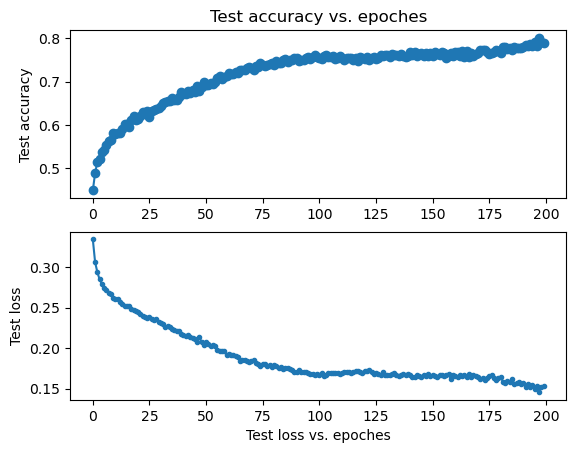

In [17]:
#accuracy_list1
draw(200,loss_list,accuracy_list1)

In [21]:
test_acc = 0
test_tp =0 
test_fp = 0  
test_tn = 0
test_fn = 0
label_sum = 0
accuracy1 = 0
for img,label,_ in test_loader:
        label = label.view(label.shape[0],-1)
        label = np.unique(label,axis=1)
        label = bcdcode(label).float()
        img,label = img.to(device),label.to(device)
        output = example(img)



        preds = torch.sigmoid(output) > 0.5  # 二进制决策  
        tp = ((preds & label.bool()).sum().item())  
        fp = ((preds & ~label.bool()).sum().item())  
        tn = ((~preds & ~label.bool()).sum().item())  
        fn = ((~preds & label.bool()).sum().item())  
        
        test_tp += tp  
        test_fp += fp  
        test_tn += tn  
        test_fn += fn
        label_sum +=label.sum().item()  
total_samples = test_tp + test_fp + test_tn + test_fn  

accuracy = (test_tp + test_tn) / total_samples
accuracy1 = test_tp/label_sum
print(accuracy,accuracy1)

0.8993055555555556 0.6811377245508982
